# CSCI E-25      
## Image Stitching 
### Steve Elston

## Introduction   

This lab demonstrates some basic principles of image stitching. The focus here is on transformation of images to a common image plane to form a mosaic. Only planar projective transforms are employed. No blending algorithms are applied.   

This lab is intended to be short and simple. The exercises are all conceptual. No coding is required.  

You can find an example which includes more sophisticated methods of blending images in this [example](https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/solutions/adv3_panorama-stitching-solution.ipynb), or in the [Scikit Image User Guide](https://scikit-image.org/docs/stable/auto_examples/registration/plot_stitching.html?highlight=stitching).   

As a first step, execute the code in the cell below to import the packages you will need.  

In [1]:
import skimage 
from skimage import data
from skimage.filters.rank import equalize
import skimage.filters as skfilters
import skimage.morphology as morphology
import skimage.transform as transform
import skimage.feature as feature
import skimage.measure as measure
from skimage.color import rgb2gray
from skimage import exposure
from PIL import Image
from skimage.feature import match_descriptors
import numpy as np
import math
from itertools import product, combinations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load and Prepare the Images

You will now load and prepare images used to create a mosaic. Execute the code in the cell below to load the image and convert it to gray-scale. 

> **Note:** You can reproduce the examples in the slide deck if you run this notebook with the `ButeScene3.JPG` image.  

(3024, 4032, 3)


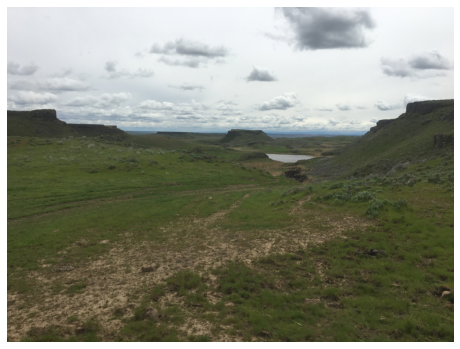

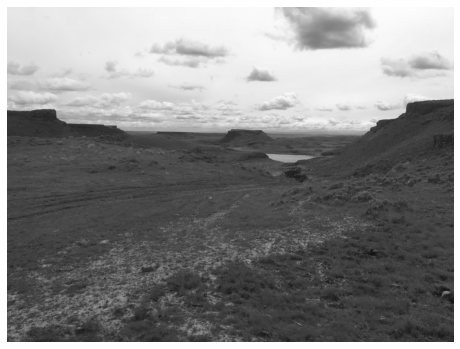

In [2]:
def plot_grayscale(img, h=8):
    plt.figure(figsize=(h, h))
    _=plt.imshow(img, cmap=plt.get_cmap('gray'))
    _=plt.axis('off');
    
bute_scene = Image.open('../datafiles/ButeScene3.JPG')
bute_scene = np.array(bute_scene)
print(bute_scene.shape)
plt.figure(figsize=(8, 8))
plt.imshow(bute_scene)
plt.axis('off')
plt.show()

bute_scene = rgb2gray(bute_scene)
plot_grayscale(bute_scene)

The code in the cell below splits the original image into two overlapping images. One of the images is then translated, rotated and scaled. In the remainder of this lab, these two images will be translated an a mosaic created which should resemble the original image.   

Execute the code in the cell below to perform the following operations:  
1. The images are cropped by opposite sift factors and then resized. The cropping retains an overlap area between the two images. 
2. A similarity transformation is applied to the right hand image. The transformation matrix is displayed.   
3. The images are displayed side by side. 

<SimilarityTransform(matrix=
    [[  1.07886381,  -0.21459935,   0.        ],
     [  0.21459935,   1.07886381, -64.        ],
     [  0.        ,   0.        ,   1.        ]])>


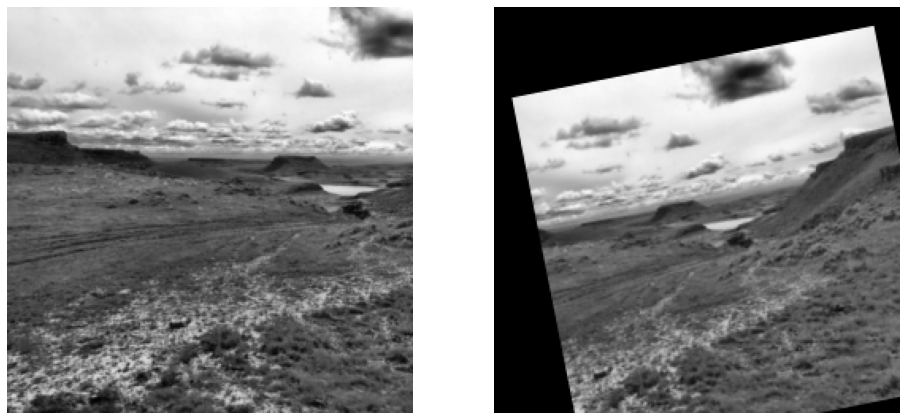

In [3]:
def plot_pair(left, right):
    fig, ax = plt.subplots(1,2, figsize=(16, 24))
    ax = ax.flatten()
    ax[0].imshow(left, cmap=plt.get_cmap('gray'))
    ax[0].axis('off');
    ax[1].imshow(right, cmap=plt.get_cmap('gray'))
    ax[1].axis('off');
    plt.show
    return ax

shift = 1000
img_dimension = 256
dimension_tuple = (img_dimension,img_dimension)
bute_left = transform.resize(exposure.equalize_adapthist(np.copy(bute_scene[:,:bute_scene.shape[1] - shift])), (dimension_tuple))
bute_right = transform.resize(exposure.equalize_adapthist(np.copy(bute_scene[:,shift:])), (dimension_tuple))


theta = math.pi/16
#theta = 0.0
scale = 1.1
#scale = 1.0
translation = [0,-64]
#translation = [0,0]
transform_matrix = transform.SimilarityTransform(rotation=theta, translation=translation, scale=scale)
print(transform_matrix)
bute_right = transform.warp(bute_right, transform_matrix)

_=plot_pair(bute_left, bute_right)

## Search for best interest point matches

The images must be transformed to a common image plane in order to form a mosaic. The transformation matrix is computed by solving a least squares problem using interest points with descriptors matching between the two images.       

There is, however, a complication with using planar transformations with images, such as the ones in our example. Strictly speaking, planar transformations are an approximation which is strictly valid only for distant objects. For objects near the camera center, planar transformations can introduce significant distortion.    

The example images have vegetation in the foreground. The vegetation has many potential interest points. Having interest points in the foreground creates problems when fitting and applying planar transformations. Fortunately, like for most images, foreground objects are at the bottom of the image. Therefore we cut off the bottom of both images when computing interest points and descriptors. 

To find interest points and their descriptor we will use [skimage.features.ORB](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.ORB) method. ORB combines several important steps for finding matching descriptors between two images:     
1. Finds interest points and descriptors at multiple scales using a Laplacian pyramid.   
2. Finds interest points using the [FAST algorithm](https://en.wikipedia.org/wiki/Features_from_accelerated_segment_test), an efficient and robust detector.    
3. Creases rotationally invariant descriptors with the rotated Brief algorithm.   
4. Provides an efficient graph search algorithm for finding matching descriptors.      

Execute the code in the cell below which performs the following operations for each image:    
1. Creates an ORB object with the desired hyperparameters.  
2. Applies the `detect_and_extract` function to the image. This function adds attributes of the the coordinates of the interest points (keypoints) along with their descriptors to the ORB object.
3. Extract the descriptor and keypoint location attributes from the ORB object. 

In [4]:
cutoff = 180

orb_left = feature.ORB(downscale=2.0, n_keypoints=600, fast_threshold=0.10, harris_k=0.2) 
temp = bute_left[:cutoff,:]
orb_left.detect_and_extract(temp)
orb_left_descriptiors = orb_left.descriptors
orb_left_keypoints = orb_left.keypoints

orb_right = feature.ORB(downscale=2.0, n_keypoints=600, fast_threshold=0.10, harris_k=0.2) 
temp = bute_right[:cutoff,:]
orb_right.detect_and_extract(temp)
orb_right_descriptiors  = orb_right.descriptors
orb_right_keypoints = orb_right.keypoints

To check on the effect of truncating the bottom of the right hand image, execute the code in the cell below. 

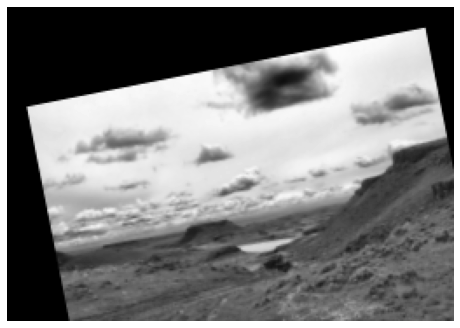

In [5]:
plot_grayscale(temp)

Execute the code in the cell below to find the matching descriptors between the two images. 

In [6]:
matches = feature.match_descriptors(orb_left_descriptiors, orb_right_descriptiors, cross_check=True)
print('Shape of the match array = ' + str(matches.shape))
print('\nHead of the match array')
print(matches[:10])

Shape of the match array = (142, 2)

Head of the match array
[[  2 178]
 [  3  18]
 [  4 123]
 [  5  14]
 [  6  23]
 [  7 232]
 [  8  15]
 [  9  21]
 [ 10   8]
 [ 11  29]]


There are 195 matching descriptors between the two images. The matches are represented by a two column numpy array. The first column indicating the descriptor index of the left image and the second column indicating the descriptor index for the right image.   

Now, plot lines between the matching keypoints by executing the code in the cell below. 

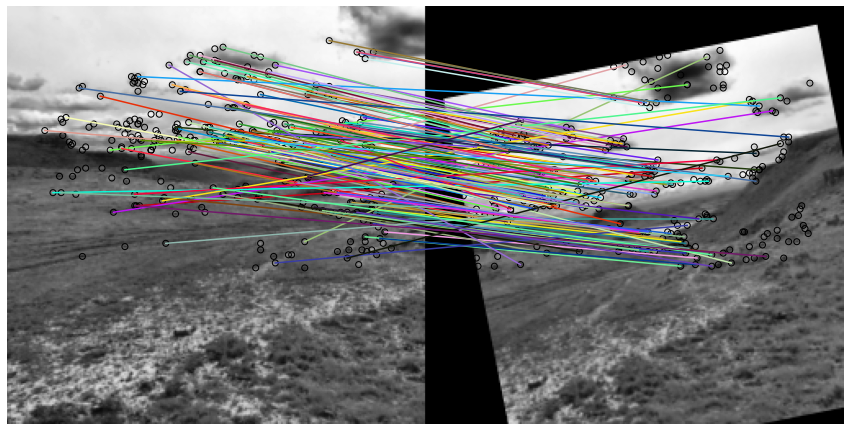

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
feature.plot_matches(ax, bute_left, bute_right, orb_left_keypoints, orb_right_keypoints, matches)
ax.axis('off');

> **Exercise 9-1:** Answer the following questions in one or two sentences:
> 1. Describe the evidence you see for outliers in these matches. 
> 2. Ignoring the outliers, examine some of the matching descriptor keypoints. Do you think these matches are reasonable given features on the two images and why? 

> **Answers:**
> 1.     
> 2.   

## Robust Transformation Fitting

With the keypoints and matched it is now time to solve a robust least squares problem using the the [skimage.measure.ransac](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.ransac) function. To do so, execute the code in the cell below which performs the following operations: 
1. Creates arrays with the coordinates of the matching keypoints for the left and right hand images.    
2. Creates a robust fit to a similarity transform model using the RANSAC algorithm. The function returns both a robustly computed transform model object and a list of logicals indicating if the match was considered an inlier.    
3. Prints the results of the RANSAC fitting process.   
4. Displays the images showing the inlier keypoint matches.   

Inlier logical array
[False  True False  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
 False False  True  True  True False  True False  True  True  True  True
  True  True  True  True  True False  True  True False  True  True False
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True False  True
  True False  True  True  True  True False  True False  True False  True
  True  True  True  True False False  True False  True  True  True  True
  True False False  True  True False False  True False False  True False
 False  True  True False  True  True False False  True  True  True  True
  True  True False  True False False  True  True  True False  True  True
 False False False  True False  True False False  True False]

Number of inliers = 99

Robust transform model
<SimilarityTransform(matrix=
    [[  0.89236464,   0.17580436, -63

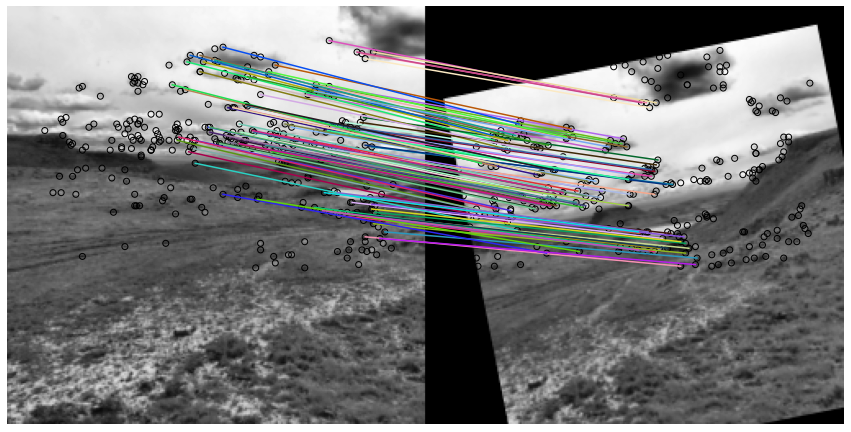

In [8]:
left_keypoints = orb_left_keypoints[matches[:, 0]][:, ::-1]
right_keypoints = orb_right_keypoints[matches[:, 1]][:, ::-1]

np.random.seed(2233)
model_robust, inliers = measure.ransac((left_keypoints, right_keypoints), transform.SimilarityTransform,
                                   min_samples=20, residual_threshold=2.0, max_trials=1000)

print('Inlier logical array')
print(inliers)
print('\nNumber of inliers = ' + str(np.sum(inliers)))
print('\nRobust transform model')
print(model_robust)

fig, ax = plt.subplots(1, 1, figsize=(15, 12))
feature.plot_matches(ax, bute_left, bute_right, orb_left_keypoints, orb_right_keypoints, matches[inliers])
ax.axis('off');

> **Exercise 9-2:** Answer the following questions in one or two sentences:   
> 1. Have a sufficient number of inliers been found to fit a similarity transform model and why? 
> 2. Consider the geometry of the location of the inlier keypoints with respect to the extent of the image. Do you think the spacing of the inlier matches is likely to create errors in accurately determining the transform matrix? 

> **Answers:**  
> 1.     
> 2.    

## Apply the Transform to Create the Mosaic

With a robust transformation matrix computed you will now use this transformation to create a mosaic of the two images. As the first step, the corners of the warped images need to be determined. These warped corners define the corners of the common image plan onto which the image mosaic is constructed. The comments in the code below explain the steps used. Execute this code and examine the results.      

In [9]:
## Set the corners of the image in a Numpy array
r, c = bute_left.shape[:2]
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

print('Corners')
print(corners)

## Find the corner points in the warped coordinate system  
warped_corners = model_robust(corners)

print('\nWarped corners')
print(warped_corners)

# Find the extents of both the reference image and the warped
# target image
corners_all = np.vstack((warped_corners, corners))

# The overall output shape will be max - min
corner_min = np.min(corners_all, axis=0)
corner_max = np.max(corners_all, axis=0)
output_shape = np.ceil((corner_max - corner_min)[::-1]).astype(int)
print('\noutput shape of mosaic = ' + str(output_shape))

Corners
[[  0   0]
 [  0 256]
 [256   0]
 [256 256]]

Warped corners
[[-63.95957599  71.79327291]
 [-18.9536586  300.23861965]
 [164.48577075  26.78735552]
 [209.49168814 255.23270226]]

output shape of mosaic = [301 320]


We have now established the corners of the warped images on the projective image plane. We can use these to compute the offset (translation) required to map the images onto the new image plane.     

The right hand image only requires only translation to the image plane. Execute the code in the cell below to perform the following operations:      
1. The offset between the two images is computed.   
2. The image is warped (translated) to the position on the image plane.   
3. A mask is created for the background around the image. 
4. The warped (translated) image has the background set to 0.    
5. The result is plotted.  

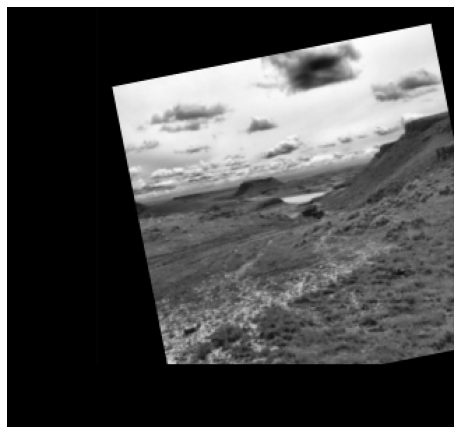

In [10]:
## Be aware that warp takes the inverse mapping as an input1
offset = transform.SimilarityTransform(translation = -corner_min)

## Translate the image
bute_right_warped = transform.warp(bute_right, offset.inverse, order=3, output_shape=output_shape, cval=-1)
bute_right_mask = (bute_right_warped != -1)  # Mask == 1 inside image
bute_right_warped[~bute_right_mask] = 0      # Return background values to 0

plot_grayscale(bute_right_warped) #[~bute_right_mask] = 0)

THe same steps are applied to the left hand image. The difference being that the offset is added as a transformation matrix and the inverse is applied. The inverse is used since we are mapping the target image.  

Execute the code in the cell below and examine the result. 

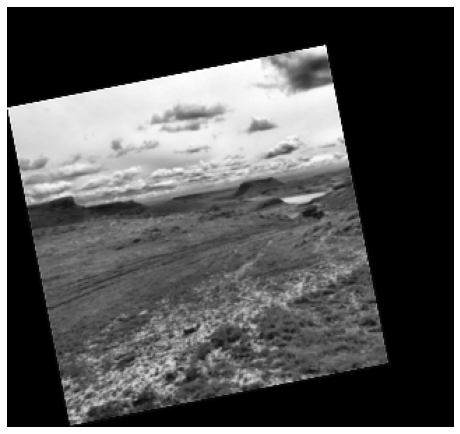

In [11]:
transform_left = (model_robust + offset).inverse
bute_left_warped = transform.warp(bute_left, transform_left, order=3, output_shape=output_shape, cval=-1)

bute_left_mask = (bute_left_warped != -1)  # Mask == 1 inside image
bute_left_warped[~bute_left_mask] = 0      # Return background values to 0

plot_grayscale(bute_left_warped)

It is now time to create a basic mosaic. Execute the code in the cell below to perform the following operations:    
1. A mask for the mosaic of the images is created.  
2. The warped images are added together and normalized.   
3. Plot the result.

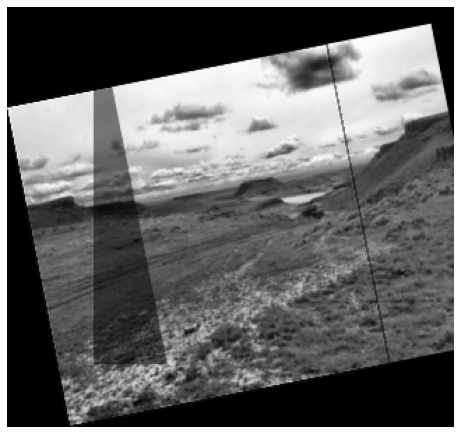

In [12]:
overlap_mask = (bute_left_mask * 1.0 + bute_right_mask)  # Multiply by 1.0 for bool -> float conversion

images_merged_normalized = (bute_left_warped + bute_right_warped)/ np.maximum(overlap_mask, 1)
plot_grayscale(images_merged_normalized)

> **Exercise 9-3:** This mosaic has some problems, visible in the jitter and blur of edges. Answer the following questions in one or two sentences.  
> 1. Which errors in computing the transformation matrix appear to have led to the poor alignment of the images.   
> 2. How do you think the tight grouping of the inlier matched keypoints gives rise to the errors you have just discussed. 

> **Answers:**   
> 1.     
> 2.    

#### Copyright 2022, Stephen F Elston. All rights reserved. 